In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [ ]:
ranked_file = r"C:\Users\surji\Desktop\Quant_Poject\Complete_analysis_200stocks\Data\Ranked Stocks\final_scored_ranked.csv"
top_n = 20
initial_capital = 100_000

ranked_df = pd.read_csv(ranked_file)
if 'Year' not in ranked_df.columns:
    raise ValueError("Ranked data must contain 'Year' column")

start_year = ranked_df['Year'].min()
end_year = ranked_df['Year'].max() + 1

portfolio_values_by_year = {}
stock_metrics = {}
stock_appearance = defaultdict(int)


In [37]:
for year in range(start_year, end_year):
    top_stocks = ranked_df[ranked_df['Year'] == year].sort_values('Rank').head(top_n)
    tickers = top_stocks['Ticker'].unique().tolist()
    if not tickers:
        print(f" No stocks to process for year {year}. Skipping.")
        continue

    start_date = f"{year}-01-01"
    end_date = f"{year+1}-01-01"
    try:
        prices = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']
    except Exception as e:
        print(f" Error downloading data for year {year}: {e}")
        continue
    
    prices = prices.dropna(axis=1, how='any')
    if prices.empty:
        print(f" No valid price data for year {year}. Skipping.")
        continue
    
    tickers = prices.columns.tolist()
    stock_appearance.update({ticker: stock_appearance[ticker] + 1 for ticker in tickers})
    
    # Calculate daily returns
    daily_returns = prices.pct_change().fillna(0)
    
    capital_per_stock = initial_capital / len(tickers)
    shares = capital_per_stock / prices.iloc[0]
    
    portfolio_daily_value = (prices * shares).sum(axis=1)
    portfolio_values_by_year[year] = portfolio_daily_value

    for ticker in tickers:
        returns = daily_returns[ticker]
        total_return = (prices[ticker].iloc[-1] / prices[ticker].iloc[0]) - 1
        days = (prices.index[-1] - prices.index[0]).days
        years_held = days / 365.25 if days > 0 else 1
        cagr = (prices[ticker].iloc[-1] / prices[ticker].iloc[0])**(1/years_held) - 1 if years_held > 0 else np.nan
        sharpe = returns.mean() / returns.std() * np.sqrt(252) if returns.std() != 0 else np.nan
        cumulative = (1 + returns).cumprod()
        max_drawdown = (cumulative.cummax() - cumulative).max() / cumulative.cummax().max()
        
        if ticker not in stock_metrics:
            stock_metrics[ticker] = {
                'Total Return': total_return,
                'CAGR': cagr,
                'Sharpe': sharpe,
                'Max Drawdown': max_drawdown,
                'Years Held': 1
            }
        else:
            prev = stock_metrics[ticker]
            n = prev['Years Held']
            stock_metrics[ticker] = {
                'Total Return': (prev['Total Return'] * n + total_return) / (n + 1),
                'CAGR': (prev['CAGR'] * n + cagr) / (n + 1),
                'Sharpe': (prev['Sharpe'] * n + sharpe) / (n + 1),
                'Max Drawdown': min(prev['Max Drawdown'], max_drawdown),
                'Years Held': n + 1
            }

C:\Users\surji\AppData\Local\Temp\ipykernel_3692\3605027404.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']
C:\Users\surji\AppData\Local\Temp\ipykernel_3692\3605027404.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']
C:\Users\surji\AppData\Local\Temp\ipykernel_3692\3605027404.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']
C:\Users\surji\AppData\Local\Temp\ipykernel_3692\3605027404.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']
C:\Users\surji\AppData\Local\Temp\ipykernel_3692\3605027404.py:1

Plotting of my whole portfolio


Overall Portfolio Performance:
Total Return: 13.01%
CAGR: 0.79%
Sharpe Ratio: 0.15
Max Drawdown: 42.20%


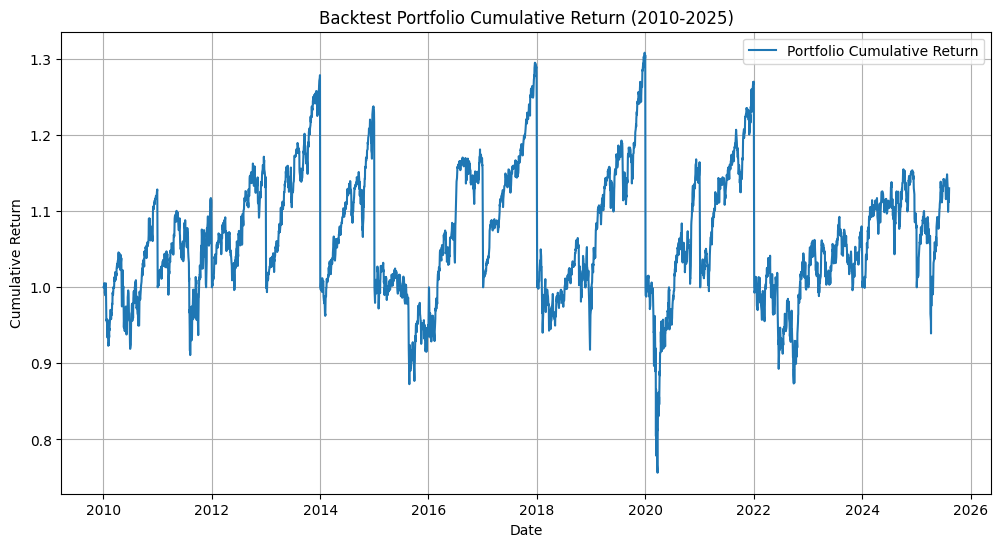

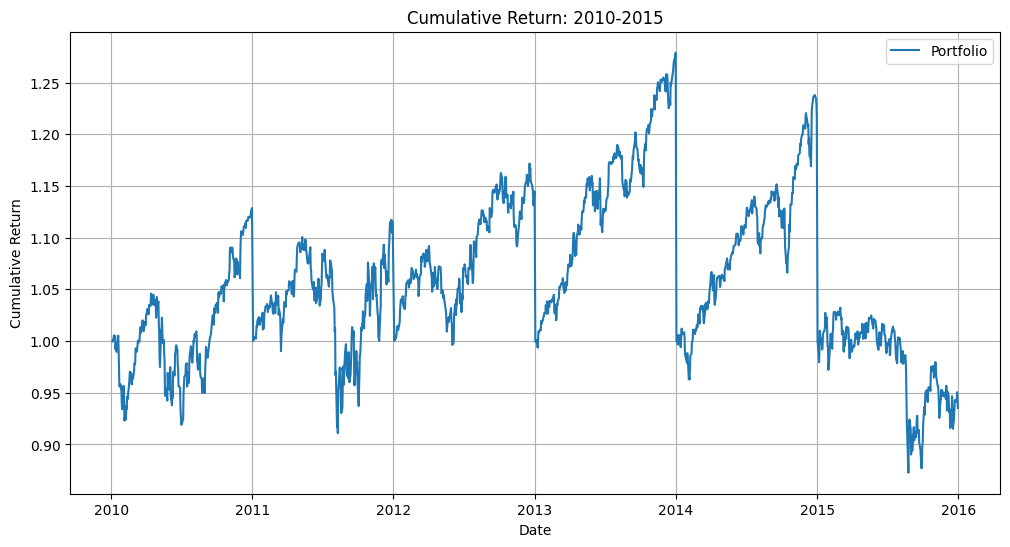

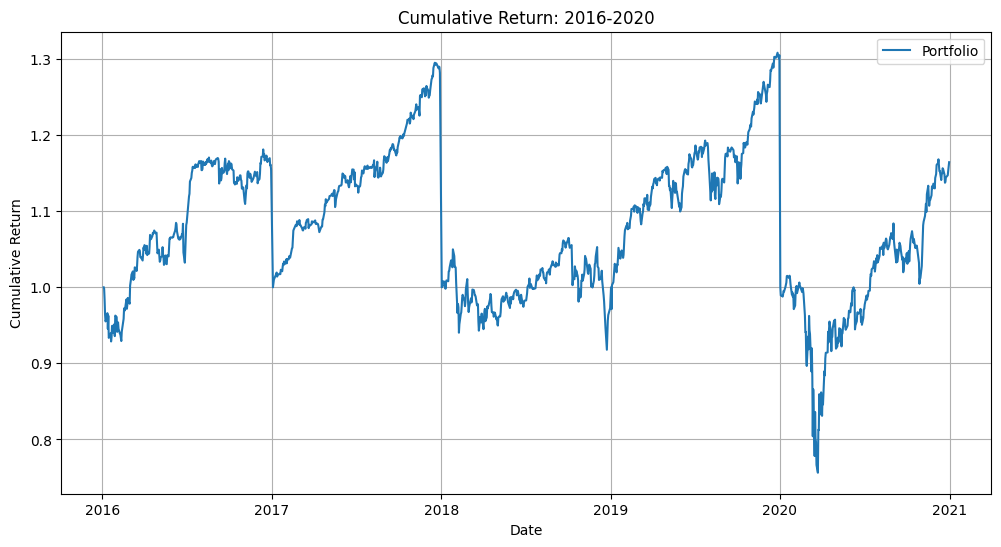

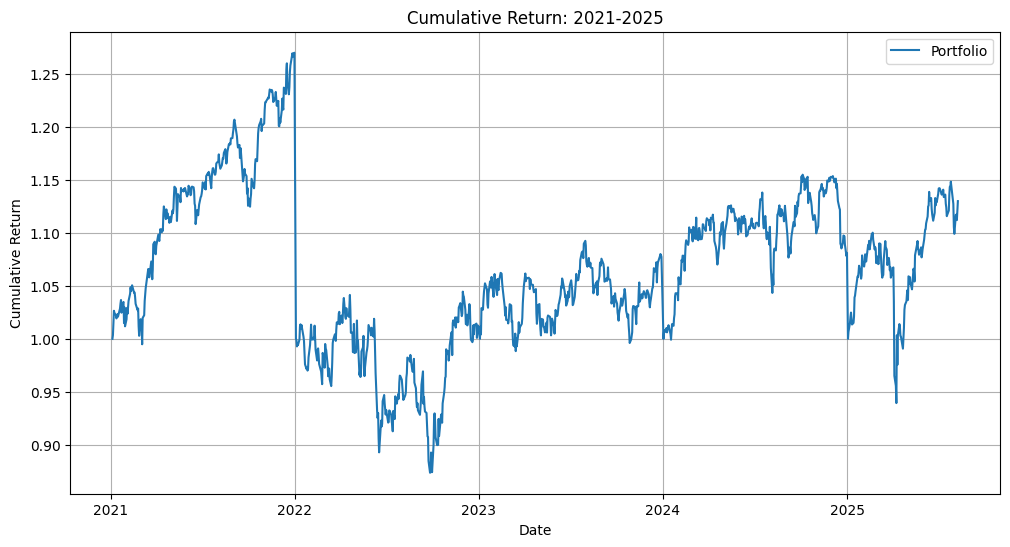


Top 20 Stocks Metrics ( According to maximum returns and risk into consideration )

LOW: CAGR=64.42%, Sharpe=2.16, Max Drawdown=10.74%, Years Held=1, Combined Score=2.70
AMAT: CAGR=65.05%, Sharpe=1.62, Max Drawdown=10.94%, Years Held=4, Combined Score=2.16
NEE: CAGR=25.52%, Sharpe=1.82, Max Drawdown=3.73%, Years Held=2, Combined Score=2.03
BAM: CAGR=44.70%, Sharpe=1.59, Max Drawdown=8.92%, Years Held=1, Combined Score=1.95
BRK-B: CAGR=25.15%, Sharpe=1.62, Max Drawdown=7.55%, Years Held=1, Combined Score=1.79
PH: CAGR=40.38%, Sharpe=1.43, Max Drawdown=10.18%, Years Held=1, Combined Score=1.73
NEM: CAGR=60.82%, Sharpe=1.22, Max Drawdown=10.51%, Years Held=4, Combined Score=1.72
AAPL: CAGR=30.72%, Sharpe=1.47, Max Drawdown=7.78%, Years Held=2, Combined Score=1.70
MSFT: CAGR=34.23%, Sharpe=1.44, Max Drawdown=9.64%, Years Held=2, Combined Score=1.69
NOC: CAGR=45.96%, Sharpe=1.34, Max Drawdown=14.19%, Years Held=1, Combined Score=1.66
ETN: CAGR=40.80%, Sharpe=1.36, Max Drawdown=17.76%, Year

In [40]:
combined_portfolio = pd.concat(portfolio_values_by_year.values()).sort_index()
combined_portfolio = combined_portfolio[~combined_portfolio.index.duplicated(keep='first')]

returns = combined_portfolio.pct_change().dropna()
total_return = combined_portfolio.iloc[-1] / combined_portfolio.iloc[0] - 1
days = (combined_portfolio.index[-1] - combined_portfolio.index[0]).days
years = days / 365.25 if days > 0 else 1
cagr = (combined_portfolio.iloc[-1] / combined_portfolio.iloc[0])**(1/years) - 1 if years > 0 else np.nan
sharpe = returns.mean() / returns.std() * np.sqrt(252) if returns.std() != 0 else np.nan
cumulative = (1 + returns).cumprod()
max_drawdown = (cumulative.cummax() - cumulative).max() / cumulative.cummax().max()

print("\nOverall Portfolio Performance:")
print(f"Total Return: {total_return*100:.2f}%")
print(f"CAGR: {cagr*100:.2f}%")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {max_drawdown*100:.2f}%")

plt.figure(figsize=(12, 6))
plt.plot(combined_portfolio.index, combined_portfolio / combined_portfolio.iloc[0], label="Portfolio Cumulative Return")
plt.title(f"Backtest Portfolio Cumulative Return ({start_year}-{end_year-1})")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

periods = {
    "2010-2015": ("2010-01-01", "2015-12-31"),
    "2016-2020": ("2016-01-01", "2020-12-31"),
    "2021-2025": ("2021-01-01", f"{end_year-1}-12-31"),
}

for label, (start, end) in periods.items():
    plt.figure(figsize=(12, 6))
    mask = (combined_portfolio.index >= start) & (combined_portfolio.index <= end)
    subset = combined_portfolio.loc[mask]
    if len(subset) > 0:
        plt.plot(subset.index, subset / subset.iloc[0], label="Portfolio")
        plt.title(f"Cumulative Return: {label}")
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        plt.legend()
        plt.grid(True)
        plt.show()

metrics_df = pd.DataFrame.from_dict(stock_metrics, orient='index')

metrics_df['Combined Score'] = metrics_df['CAGR'] + metrics_df['Sharpe'] - metrics_df['Max Drawdown']

metrics_df_sorted = metrics_df.sort_values(by='Combined Score', ascending=False)

print("\nTop 20 Stocks Metrics ( According to maximum returns and risk into consideration )\n")
top_20 = metrics_df_sorted.head(20)
for ticker, row in top_20.iterrows():
    print(f"{ticker}: CAGR={row['CAGR']*100:.2f}%, Sharpe={row['Sharpe']:.2f}, Max Drawdown={row['Max Drawdown']*100:.2f}%, Years Held={int(row['Years Held'])}, Combined Score={row['Combined Score']:.2f}")

print("\nStock Appearance Count (years in portfolio):")
for ticker, count in sorted(stock_appearance.items(), key=lambda x: x[1], reverse=True)[:20]:
    print(f"{ticker}: {count} years")


Plotting of my Initail Capital Growth 

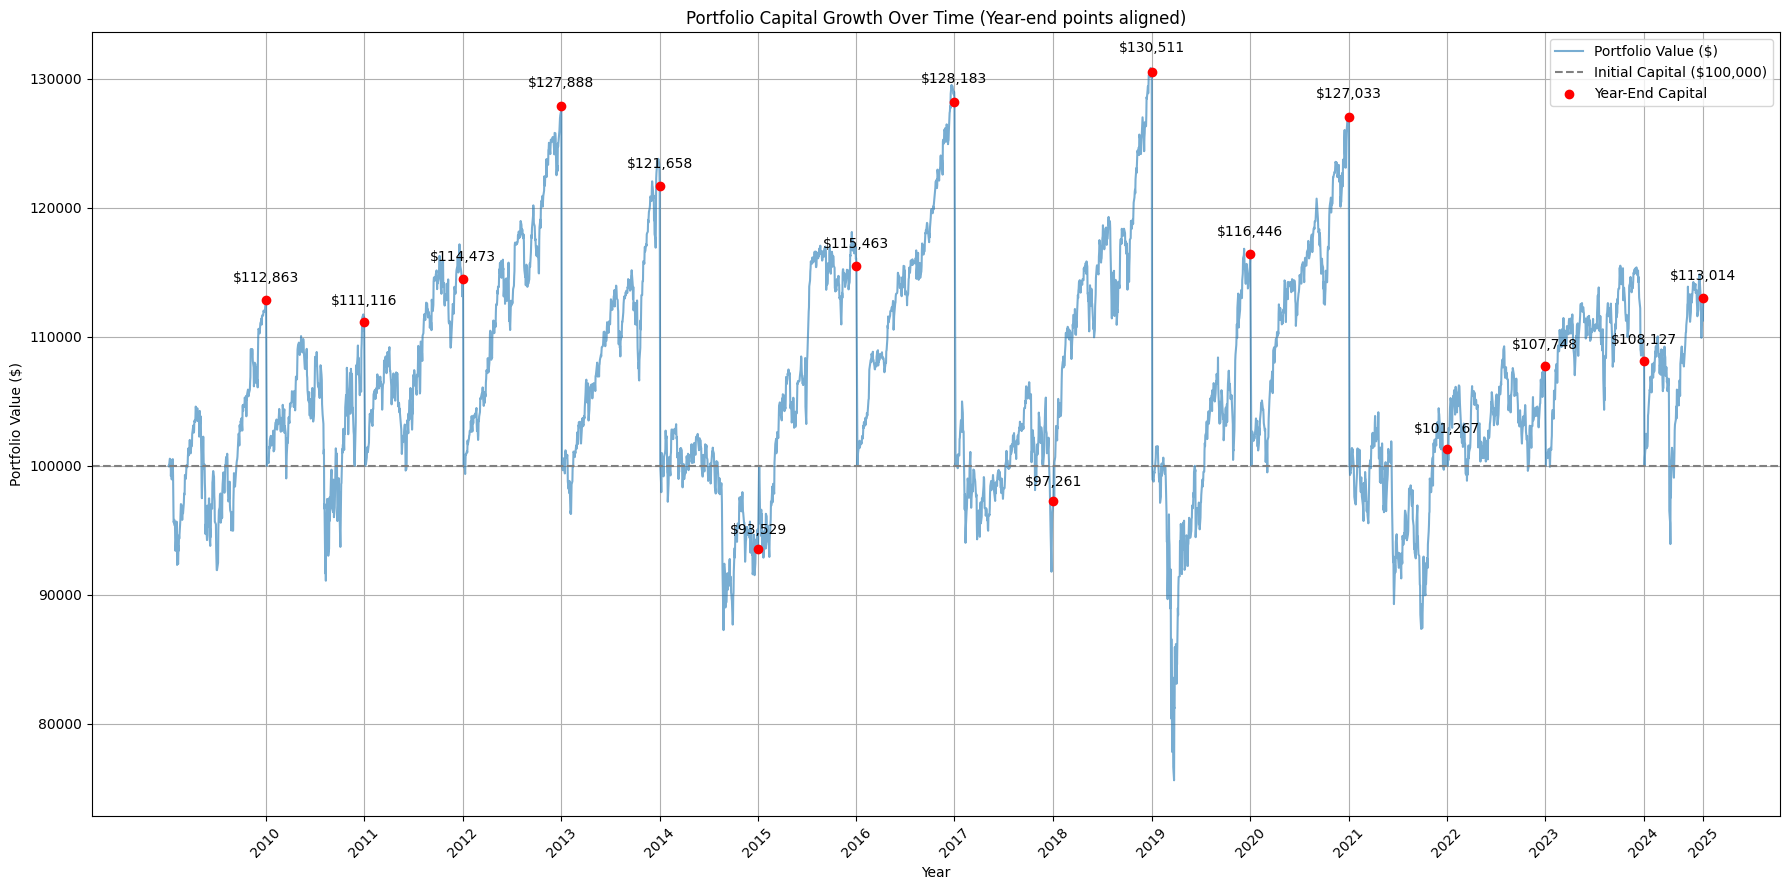


📅 Capital at the End of Each Year:
2010: $112,862.82
2011: $111,115.55
2012: $114,472.81
2013: $127,887.99
2014: $121,657.74
2015: $93,529.20
2016: $115,463.04
2017: $128,182.77
2018: $97,260.97
2019: $130,511.15
2020: $116,446.10
2021: $127,032.70
2022: $101,267.48
2023: $107,748.24
2024: $108,127.04
2025: $113,013.95


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

years = list(range(start_year, end_year))
year_end_dates = []
year_end_capitals = []
for y in years:
    if y in portfolio_values_by_year and not portfolio_values_by_year[y].empty:
        last_dt = portfolio_values_by_year[y].index[-1] 
        cap = portfolio_values_by_year[y].iloc[-1]
    else:
        last_dt = pd.Timestamp(f"{y}-12-31")
        cap = float('nan')
    year_end_dates.append(last_dt)
    year_end_capitals.append(cap)

plt.figure(figsize=(18, 9))
plt.plot(combined_portfolio.index, combined_portfolio, label='Portfolio Value ($)', alpha=0.6)
plt.axhline(initial_capital, color='gray', linestyle='--', label=f'Initial Capital (${initial_capital:,})')

valid_idx = [i for i, v in enumerate(year_end_capitals) if not pd.isna(v)]
valid_dates = [year_end_dates[i] for i in valid_idx]
valid_caps  = [year_end_capitals[i] for i in valid_idx]
valid_years = [years[i] for i in valid_idx]

plt.scatter(valid_dates, valid_caps, color='red', zorder=5, label='Year-End Capital')

for d, cap, y in zip(valid_dates, valid_caps, valid_years):
    plt.text(d, cap * 1.01, f"${cap:,.0f}", ha='center', va='bottom', fontsize=10)

plt.xticks(year_end_dates, [str(y) for y in years], rotation=45)

plt.title('Portfolio Capital Growth Over Time (Year-end points aligned)')
plt.xlabel('Year')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the table as well (for verification)
print("\n📅 Capital at the End of Each Year:")
for y, cap in zip(years, year_end_capitals):
    if pd.isna(cap):
        print(f"{y}: No data")
    else:
        print(f"{y}: ${cap:,.2f}")


Saving the two files 
1. Best_stock_returns - ( TOP STOCK ACCORDING TO CAGR + SHARPE RATIO - MDD )
2. Best_stock_stable_combined - ( TOP STOCKS BASED ON LONG TERM STABILITY )

In [ ]:
metrics_df['Combined Score'] = metrics_df['CAGR'] + metrics_df['Sharpe'] - metrics_df['Max Drawdown']
metrics_df_sorted = metrics_df.sort_values(by='Combined Score', ascending=False)
max_returns_file = r"C:\Users\surji\Desktop\Quant_Poject\Complete_analysis_200stocks\Data\Results\best_stocks_max_returns.xlsx"
metrics_df_sorted.to_excel(max_returns_file, index_label='Ticker')

appearance_df = pd.DataFrame.from_dict(stock_appearance, orient='index', columns=['Appearance Count'])
combined_df = metrics_df_sorted.merge(appearance_df, left_index=True, right_index=True, how='left')
combined_df['Appearance Count'].fillna(0, inplace=True)

def min_max_normalize(s):
    return (s - s.min()) / (s.max() - s.min()) if s.max() != s.min() else 1

combined_df['Combined Score Norm'] = min_max_normalize(combined_df['Combined Score'])
combined_df['Appearance Count Norm'] = min_max_normalize(combined_df['Appearance Count'])

weight_combined_score = 0.7
weight_appearance = 0.3
combined_df['Final Score'] = (weight_combined_score * combined_df['Combined Score Norm'] +
                              weight_appearance * combined_df['Appearance Count Norm'])

combined_df_sorted = combined_df.sort_values(by='Final Score', ascending=False)

combined_df_sorted = combined_df_sorted.drop(columns=['Appearance Count Norm'])

stable_combined_file = r"C:\Users\surji\Desktop\Quant_Poject\Complete_analysis_200stocks\Data\Results\best_stocks_stable_combined.xlsx"
combined_df_sorted.to_excel(stable_combined_file, index_label='Ticker')

print("\n\n <-- BOTH THE FILES SAVED -->\n\n\n")



 <-- BOTH THE FILES SAVED -->





C:\Users\surji\AppData\Local\Temp\ipykernel_3692\3234307662.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['Appearance Count'].fillna(0, inplace=True)
